# Lesson 2: Training a neural network

This notebook introduces a neural network and shows how to train it to fit an arbitrary function.

Besides setting up the network, you will learn about jax random numbers, batch processing (using ```jax``` ```vmap```), taking gradients with respect to the parameters of a network, and running the training loop.

(C) 2024 Florian Marquardt, Max Planck Institute for the Science of Light (MIT License)

## Imports

Besides ```matplotlib``` and ```jax.numpy``` and ```optax```, we now also import powerful additional ```jax``` commands like ```vmap```, ```jit```, ```value_and_grad``` and ```jax.random``` random number generation. Together, they are practically everything you will need.

In [4]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import jax
import jax.random

import optax

## Defining a neural network

Mathematically, an artificial neural network is simply a nonlinear function that depends on many parameters which will be adjusted during training. It has a specific structure modeled on a cartoon of the brain, with artificial neurons that are connected to each other in layers. At any given time, each neuron holds only one value, being much simpler than an actual biological neuron.

### The structure of an artificial neural network

**Calculating the output of a neural network** -- A neural network consists of neurons arranged into layers. The "activation values" of the neurons in a layer form a vector. To go from one layer to the next, one multiplies the "weight" matrix $w$ onto this vector and adds a bias vector $b$. 

$$
z_j = \sum_l w_{jl} x_l + b_j
$$

On top of that, one applies a nonlinear "activation function" $f$ to each entry in the resulting vector separately:

$$
x_j^{\rm new} = f(z_j)
$$

Using python and ```jax.numpy``` syntax, we can write these steps as:

```python
z = jnp.matmul( w, x ) + b
x = f( z )
```

Overall, this combination of a linear and a nonlinear operation results in a new vector, representing the activation values in the next layer. This process can be repeated for several layers until one finally arrives at the output layer, where one can return the activation vector to the user.

The network structure we define here is the default, and it is sometimes called a "fully connected" network or a "multilayer perceptron". Alternative structures exist that are taylored to specific purposes.

**Simple neural network** -- With everything we said so far, we can define the function that evaluates a neural network when given the input vector ```x```, like this:

```python
def NN( x, weights, biases ):
    for w,b in zip(weights,biases):
        x = jnp.matmul( w, x ) + b
        x = f( x )
    return x 
```

Here we assumed that ```weights``` would be a list of all weight matrices, and ```biases``` a list of all bias vectors. Also note that we did not introduce a ```z``` variable as an intermediate result, since it is not really necessary.

**Shape of the weight matrices** -- Regarding the shape of the matrix $w$ for a given layer: Obviously, it is of shape $M \times N$, where $M$ would be the number of neurons in the next layer and $N$ the number of neurons in the previous layer. Since the number of neurons may (and usually does) change from layer to layer, all these weight matrices usually have different shapes, just like the bias vectors. If there are $n$ layers, including the input and output layer, then there will be $n-1$ weight matrices and $n-1$ bias vectors.

**Accessing the parameters** -- The weights and biases together form the parameters of the network. For simplicity, it is useful to collect them all in a single variable, let us call it  ```params```. This variable might simply be a list of all weight matrices and bias vectors, but we find it useful to arrange it as a dictionary: ```params['weights']``` will hold a list of all the weight matrices, starting with the weight matrix connecting the lowest (input) layer to the first layer, and so on. Likewise ```params['biases']``` holds all the bias vectors. Then our network only has two arguments, the input and the parameters. This will be the standard form we work with:

```python
def NN( x, params ):
    for w,b in zip(params['weights'],params['biases']):
        x = jnp.matmul( w, x ) + b
        x = f( x )
    return x 
```

In the particular neural network below, which we will use in this notebook, we chose to apply ```tanh``` as a nonlinear activation function ```f```, but many other choices are possible and are used. Also, we do not apply this nonlinear activation in the last step (going towards the output layer), since we want to make sure the output vector values can have an arbitrary range and are not restricted between -1 and 1. This is also quite standard procedure.

In [5]:
def NN(x, params):
    """
    Standard multilayer perception "MLP" with params['weights'] and params['biases'],
    applied to input vector x. Activation tanh applied to all
    layers except last.
    
    Returns activation vector of the output layer.
    """
    num_layers=len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'],params['biases'])):
        x = jnp.matmul(w,x) + b
        if layer_idx < num_layers-1:
            x = jnp.tanh( x )
    return x

### Initializing the network parameters (a bit about jax random numbers)

One has to initialize the weight matrices and maybe biases in some suitable random fashion. 

**Random numbers in jax** -- To do this, we have to briefly learn about random number generation in ```jax```. You may be used to simply call a random-number-generator like ```random()``` whenever you need a random number. However, having a 'function' like this which returns different results whenever you call it again is weird. It contradicts the behaviour of usual mathematical functions and goes against the concepts of "functional programming" on which ```jax``` is built.

Therefore, in ```jax``` we proceed like this:

```python
key = jax.random.key( 42 ) # get an initial random "key" from a seed, here 42

subkey, key = jax.random.split( key )
random_vector = jax.random.normal( subkey, [10] )

...

subkey, key = jax.random.split( key )
random_matrix = jax.random.normal( subkey, [7,8] )

...
```

This will set up a random "key" (the internal state of a random number generator). Then, whenever we want to produce random arrays, we first call the ```jax.random.split``` function in the way shown here, to split off a subkey. This subkey we then pass to a random-number generating function like ```jax.random.normal``` which procudes Gaussian random numbers (here, a vector of size 10 and later a matrix of shape ```[7,8]```). You can proceed in this way forever and get a fully reproducible stream of random results. It becomes quite simple once you get used to this. If you want to produce random numbers inside a function, pass a subkey into this function.

**Scaling the network weights** -- To keep the magnitude of neuron activations under control, we rescale the weight matrix entries by $1/\sqrt{N}$ where $N$ is the neuron number in the previous layer. This is standard practice, and it leads to neuron activations of order 1 if the previous layer activations were randomly Gaussian distributed with spread $1$.

With all these remarks, here is the little function that produces randomly initialized weights:

In [6]:
def NN_init_params(key, num_neurons_layers):
    """
    Given a jax random key and a list of the neuron numbers
    in the layers of a network (simple fully connected network,
    i.e. 'multi-layer perceptron'), return a dictionary
    with the weights initialized randomly and biases set to zero.
    
    Returns: params, with params['weights'] a list of matrices and
    params['biases'] a list of vectors.
    """
    params = {}
    params['weights'] = []
    params['biases'] = []
    
    for lower_layer, higher_layer in zip( num_neurons_layers[:-1], num_neurons_layers[1:] ):
        key,subkey = jax.random.split( key )
        params['weights'].append( jax.random.normal( subkey,
                                        [higher_layer,lower_layer] ) /  
                                 jnp.sqrt( lower_layer ) )
        
    for num_neurons in num_neurons_layers[1:]:
        params['biases'].append( jnp.zeros( num_neurons) )
    
    return params

### A first test: setting up a randomly initialized network

We now initialize network parameters for a network with a single input neuron and a single output neuron. In other words, it represents a scalar function of a single scalar argument. This network has two "hidden" layers, with 30 and 20 neurons.

In [7]:
key = jax.random.key( 45 )

num_hidden_1 = 30 # number of neurons in hidden layer 1
num_hidden_2 = 20

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [1, num_hidden_1, num_hidden_2, 1] )

We can now apply our randomly initialized network to some input value. Note that the input must be given as an array, although of course here it is a trivial array - a vector of length 1. The output is likewise such an array.

In [8]:
NN( jnp.array([1.5]), params )

Array([-0.5805124], dtype=float32)

### Batch processing in jax (the power of vmap)

We want to plot the output of this network for various values of the input. Ideally, we do ***not*** want to run a for loop over all possible input values, which would be slow.

In machine learning, this is the point where one introduces "batch processing". Instead of passing just a single input to the network, one passes a batch. If originally one had an input vector of shape ```[n_input]``` one now wants to pass a batch of shape ```[batchsize, n_input]``` which contains ```batchsize``` different input vectors. This can then be processed in a single run, using e.g. the power of a GPU (or at least the power of vectorized processing in numpy, even on a CPU).

```jax``` offers the extremely powerful ```vmap```  ("vectorizing map") to take care of this. You give ```vmap```  an arbitrary function (such as our neural network function) and tell it to create a new function out of that. This new function can have an additional batch dimension for some of the arguments. Let's do this here!

In [10]:
NN_batch = vmap( NN, in_axes = [0,None],
             out_axes = 0)

Here ```in_axes``` is telling ```vmap``` that we want a batch dimension for the first argument (the vector ```x```), and that this new batch dimension is the dimension 0. On the other hand, the second argument of the network would be ```params```, and we do not want those to have a batch dimension - otherwise every sample in the batch would be processed using different weights and biases. This is indicated by the ```None```. The ```out_axes``` just indicates where the batch dimension is in the output, and we choose it also as 0.

Now let's apply this to an example, where we want to evaluate the network on a sweep of values and plot the result!

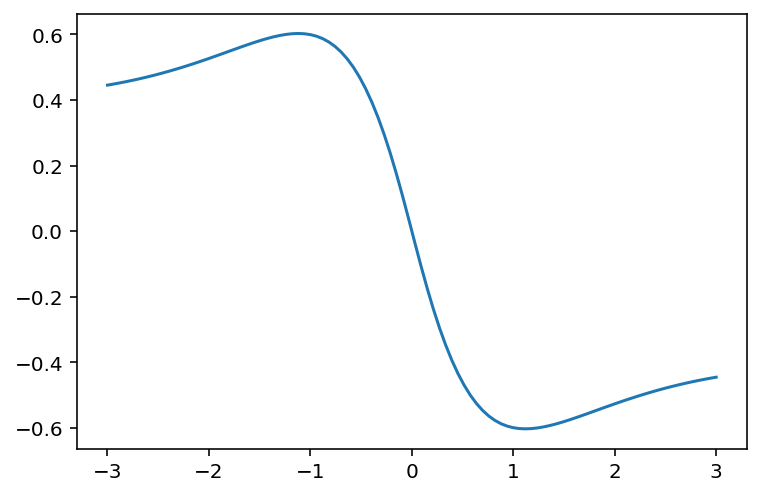

In [11]:
# create a sweep in x, but convert the shape to [100,1]
# where 100 is the batchsize and '1' is the original input dimension
# required for the network:
batchsize = 100
x = jnp.linspace( -3.0, +3.0, batchsize )[:,None]

plt.plot( x[:,0], NN_batch( x, params ) )
plt.show()

This is still a bit boring (mainly because we chose to initialize biases to zero). Let's quickly change the biases by hand to something interesting. During actual neural network training, they would become interesting with time anyway:

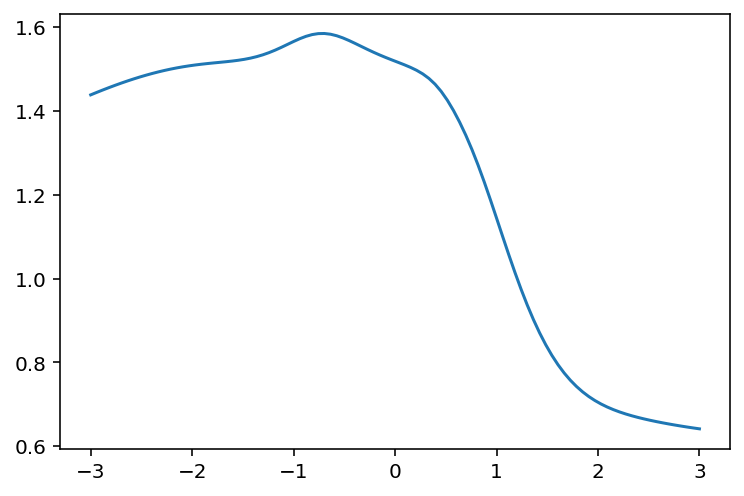

In [12]:
params['biases'] = [ jnp.full(num_hidden_1,-1.5), jnp.full(num_hidden_2, 1.3), jnp.full(1, 0.0) ]

plt.plot( x[:,0], NN_batch( x, params ) )
plt.show()

### The loss function and its gradient

For network training, we have to define a loss function that indicates the deviation between the desired results (often called ```y_target```) and the actual output of the network. Here, we want to compute this loss already averaged over a whole batch of samples. Therefore, we do it like this. Note that this loss function calls the neural-network function, and therefore it needs to know the network parameters, to pass them along!

In [13]:
# batch-averaged mean-square-error deviation between x and y_target:
def mse_loss_batch(x, y_target, params):
    return jnp.sum( ( NN_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]


We now also calculate the gradient of the loss function. This is super easy, since we have the power of ```grad``` at our fingertips, which can also be applied in this case.

In [14]:
# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss:
mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=2)

Two remarks: 

**Value and Gradient together** -- First, we use the nice ```value_and_grad``` function, which produces a function that returns both the value (i.e. here the loss) and the gradient with respect to parameters (here the network parameters have become argument number '2' of mse_loss_batch, and we have to indicate this).

**Taking gradients with respect to a complicated data structure** -- Second, you may wonder how ```jax``` can take the gradient with respect to ```params```. After all, ```params``` is a dictionary which contains lists of arrays. That is, ```params``` seems a complicated-looking data structure. But this is no problem for ```jax```. It will nicely calculate the gradient of the ```mse_loss_batch``` function with respect to ***every*** matrix or vector that is sitting somewhere within this nested dictionary / list. And it will output a "gradient" result that has exactly the same shape, i.e. the same nested dictionary / list, with every array replaced with the corresponding gradient. Don't worry, it just works! If you want to read more about this, look for "pytree" in the jax documentation.

**Speeding up things via compilation** -- We can also speed up things by applying ```jax.jit```. This compiles ("just in time"), so the code runs much faster, either on CPU or GPU, depending on your installation.

In [15]:
mse_loss_batch_val_grad = jax.jit( mse_loss_batch_val_grad  )

## Training the neural network

We will now train our network to approximate an arbitrary function. For that purpose, we define a function (which you can change if you like), and then we sample random locations $q$ and calculate $F(q)$. 

In [16]:
# our "true" function that we want to fit using
# the neural network:
def F(q):
    return jnp.exp( - q**2 ) * jnp.sin( 5 * q )

We train the network to reproduce those values as well as it can. Of course, we again use ```optax``` like in the previous chapter, so we have to set up an optimizer that can be used in the training loop for updating the ```params``` parameters of the neural network. Let us therefore now randomly initialize the network and also set up this optimizer:

In [17]:
# again, initialize network randomly:

num_hidden_1 = 30 # number of neurons in hidden layer 1
num_hidden_2 = 20

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [1, num_hidden_1, num_hidden_2, 1] )

learning_rate = 1e-2

# get the optimizer:
optimizer = optax.adam( learning_rate )
# initialize the 'state' of the optimizer, by
# telling it about the initial values:
opt_state = optimizer.init( params )

Before we run the training loop, let us define parameters like the batchsize, the number of training batches we want to consider, and in this case the range of random x values where we draw samples from. We also set up an array ```losses``` in which we will store the evolution of the loss during training.

In [18]:
# training parameters
num_training_batches = 100
batchsize = 32
x_range = [-3.0, 3.0]
losses=[]

Now let us go for the training loop! In each iteration, it creates a random batch of training samples, then evaluates the gradient of the loss, and finally updates the neural network parameters. Except for the details of creating the training samples, this is completely generic and you can reuse it for all kinds of network training tasks.

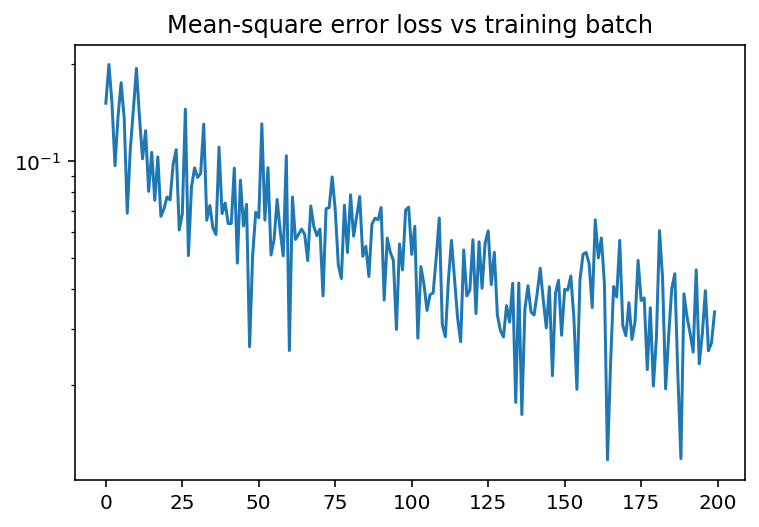

In [20]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch, by evaluating F at
    # random locations:
    subkey,key = jax.random.split( key )
    x = jax.random.uniform( subkey, [batchsize, 1], minval = x_range[0], maxval = x_range[1])
    y_target = F( x ) # the true values
    
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state )
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

Now let us plot the output of the network and the true function together (network output in blue, true function in orange). We deliberately plot the results a bit outside the training range -3..3, to see whether the network generalizes reasonably (often, it can not!).

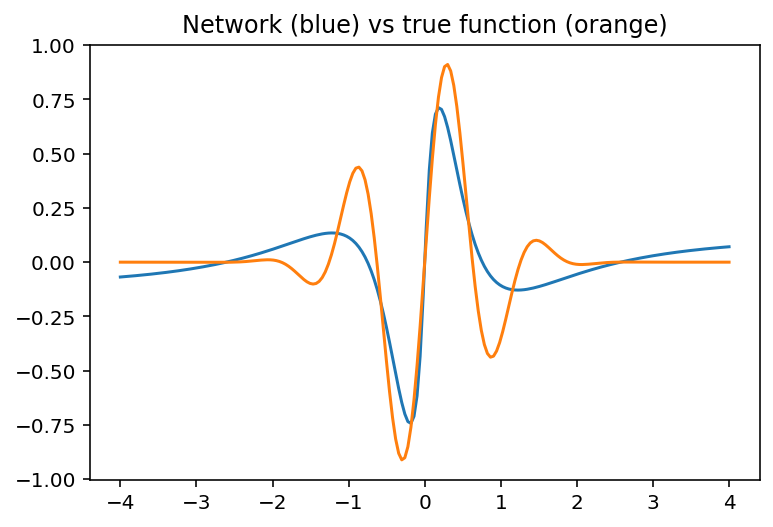

In [21]:
x = jnp.linspace( -4.0, 4.0, 200 )[:,None]
net_output = NN_batch( x, params )

plt.plot( x, net_output )
plt.plot( x, F( x ))
plt.title("Network (blue) vs true function (orange)")
plt.show()

```{admonition} Exercise
Run training a few more times and see how the result improves!
```

```{admonition} Exercise
Try a different function F( x ) and start the training again!
```

While this example, curve fitting, may seem a bit simple, let us emphasize the following: The input vectors could have had any dimensionality, and likewise the output vectors. That is, we could fit an arbitrary high-dimensional function (only visualization becomes more difficult). In addition, we actually do not need the explicit expression for the function. Someone might give us experimental data or we might extract function values from expensive simulations and teach the network to reproduce those (and eventually give us results at inputs that were never supplied during training).

In other words, this example already shows ***everything*** there is for basic construction of neural networks and training. Once we have more interesting training data, we can get really impressive results.